In [15]:
import pandas as pd
import numpy as np
import re
import datetime
import math
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
import geopandas as gpd
import h3 # h3 bins from uber
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, minmax_scale
import scipy.cluster.hierarchy as sch
#pd.set_option('display.max_rows', None)


In [88]:
def create_crash_df(train_file = '../Inputs/Train.csv'):  
    '''
    loads crash data from input folder into dataframe
    '''
    crash_df = pd.read_csv(train_file, parse_dates=['datetime'])
    return crash_df
    
def create_temporal_features(df, date_column='datetime'):
    '''
    Add the set of temporal features the the df based on the datetime column. Returns the dataframe.
    '''
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 
                    6: "15-18", 7: "18-21", 8: "21-24"}
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                   7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    rainy_season = ["Mar", "Apr", "May", "Oct", "Nov", "Dec"]
    df["time_window"] = df[date_column].apply(lambda x: math.floor(x.hour / 3) + 1)
    df["time_window_str"] = df["time_window"].apply(lambda x: dict_windows.get(x))
    df["day"] = df[date_column].apply(lambda x: x.day)
    df["month"] = df[date_column].apply(lambda x: dict_months.get(x.month))
    df["year"] = df[date_column].apply(lambda x: x.year)
    df["weekday"] = df[date_column].apply(lambda x: x.weekday())
    df["rainy_season"] = df["month"].apply(lambda x: 1 if (x in rainy_season) else 0)
    return df

def drop_temporal(df):
    '''
    helper function to remove all the granular temporal columns once they have been used for generating other columns for joining.
    '''
    df = df.drop(["day", "time_window","time_window_str","time_window_str","month", "year", "weekday", "rainy_season", "cluster"], axis=1)
    return df

def assign_hex_bin(df,lat_column="latitude",lon_column="longitude"):
    '''
    Takes lat,lon and creates column with h3 bin name for three levels of granualirity.
    '''
    df["h3_zone_5"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 5),axis=1)
    df["h3_zone_6"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 6),axis=1)
    df["h3_zone_7"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 7),axis=1)
    return df

def plot_centroids(crash_data_df, centroids, cluster='cluster'):
    '''
    plots the crash data points from crash_data_df and overlays the ambulance location from centroids. 
    Can be used in a loop by giving 'cluster' value as a parameter to label the chart with the cluster name.
    '''
    
    fig, axs = plt.subplots(figsize=(8, 5))
    plt.scatter(x = crash_data_df['longitude'], y=crash_data_df['latitude'], s=1, label='Crash locations' )
    plt.scatter(x = centroids[:,1], y=centroids[:,0], marker="x",
                color='r',label='Ambulances locations',s=100)
    axs.set_title('Scatter plot : Ambulaces locations vs Crash locations :'+cluster)
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.legend()
    plt.show()

def plot_k_means(crash_df_with_cluster):
    '''
    Runs mulitple k-means clustering on the crash_df based on the split of tw clusters in the 'cluster' column.
    Feeds the crash data points and the resulting centroids for that cluster into the plot centroids function.
    return once chart for each cluster.
    '''
    for i in crash_df_with_cluster.cluster.unique():
        kmeans = KMeans(n_clusters=6, verbose=0, tol=1e-3, max_iter=100, n_init=20, copy_x= True)
        kmeans.fit(crash_df_with_cluster.query('cluster==@i')[['latitude','longitude']])
        centroids = kmeans.cluster_centers_
        plot_centroids(crash_df_with_cluster.query('cluster==@i'), centroids=centroids) 
        
def plot_dendrogram(df):
    '''Use Dendrogram to determine an optimal number of clusers'''
    plt.figure(figsize=(45,18))
    plt.title('Androgram')
    plt.xlabel('time_buckets_days')
    plt.ylabel('Euclidean distances')
    dendrogram = sch.dendrogram(sch.linkage(df, method = 'ward'))
    plt.show()

def calculate_TW_cluster(crash_df, method='MeanShift', verbose = 1):
    '''
    Takes crash dataframe with temporal features added as input
    Function to perform clustering of time windows and assign labels back to crash dataframe. 
    Output is dataframe with additional column for labels
    If verbosity is increased, information about the clusters to printed.
    '''
    group_stats = crash_df.groupby(['time_window_str', 'weekday'])
    group_stats = group_stats.agg({'latitude': [np.mean, np.std],'longitude': [np.mean, np.std, 'count']})
    # flatten out groupby object and name columns again
    group_stats = group_stats.reset_index()
    group_stats.columns = group_stats.columns.get_level_values(0)
    group_stats.columns.values[[2,3,4,5,6]] = ['latitude_mean', 'latitude_std',
                                               'longitude_mean', 'longitude_std', 'RTA_count']
    X = group_stats.loc[:,['RTA_count']]#, 'latitude_mean', 'latitude_std','longitude_mean', 'longitude_std']]
    scaler = StandardScaler()
    scale_columns = ['latitude_mean', 'latitude_std','longitude_mean', 'longitude_std']
    #X[scale_columns] = scaler.fit_transform(X[scale_columns])
    if verbose > 5:
        X1 = X.copy()
        X1['RTA_count'] = minmax_scale(X1['RTA_count'])
        plot_dendrogram(X1)
        
    if method == 'MeanShift':
        #X['RTA_count'] = minmax_scale(X['RTA_count'])
        ms_model = MeanShift().fit(X)
        labels = ms_model.labels_

    elif method == 'GMM':
        X['RTA_count'] = minmax_scale(X['RTA_count'])
        gmm = GaussianMixture(n_components=4, verbose=verbose, random_state=42)
        gmm.fit(X)
        labels = gmm.predict(X)
    else:
        display('Select method "MeanShift" or "GMM"')
        #return 'error'

    labels = pd.DataFrame(labels,columns=['cluster'])
    clustered_time_buckets = pd.concat([group_stats,labels], axis=1)

    if verbose > 0:
        display(clustered_time_buckets.groupby('cluster').agg({'RTA_count': ['count', np.sum]}))
    if verbose > 1:
        plot_TW_cluser(clustered_time_buckets)
    
    crash_df = crash_df.merge(clustered_time_buckets[['time_window_str', 'weekday','cluster']], how='left', on=['time_window_str', 'weekday'])
    return crash_df

def plot_TW_cluser(clustered_time_buckets):
    '''
    Displays stripplot to show how different times of the week are assigned to TW clusters.
    '''
    tb_clusers = sns.FacetGrid(clustered_time_buckets,hue='cluster', height=5)
    tb_clusers.map(sns.stripplot,'weekday', 'time_window_str', s=25, order = ['00-03', '03-06', '06-09', '09-12', 
                                                                              '12-15', '15-18', '18-21', '21-24'])
    
def assign_TW_cluster(weekday, time_window, holiday=0, strategy='baseline'):
    '''
    Can be used in a lambda function to return the time window cluster for a given day and time window.
    e.g. crash_df["cluster"] = crash_df.apply(lambda x: return_TW_cluster(x.weekday, x.time_window_str) ,axis=1)
    This is called by the function: create_cluster_feature.
    '''
    if strategy == 'baseline':
        if holiday == 1:
            return 'off_peak'        
        elif weekday == 6:
            return 'off_peak'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'peak'
    
    elif strategy == 'saturday_2':
        if holiday == 1:
            return 'off_peak'        
        elif weekday == 6:
            return 'off_peak'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'peak'         

def create_cluster_feature(crash_df, strategy='baseline', verbose = 0):
    '''
    Function takes crash df and creates new column with tw cluster labels.
    If verbose is increased, the time window clusters will be visualised.
    '''
    crash_df["cluster"] = crash_df.apply(lambda x: 
                                         assign_TW_cluster(weekday=x.weekday,
                                                           time_window=x.time_window_str,
                                                           strategy=strategy) 
                                         ,axis=1)
    print(f'{crash_df.cluster.nunique()} clusters created')
    if verbose > 0:
        tb_clusters = sns.FacetGrid(crash_df,hue='cluster', height=5)
        tb_clusters.map(sns.stripplot,'weekday', 'time_window_str', s=25, 
                                       order = ['00-03', '03-06', '06-09', '09-12', 
                                                '12-15', '15-18', '18-21', '21-24'],
                                    label = 'Time Window Clusters')
    return crash_df
            

def create_baseline_submission_df(crash_data_df, date_start='2019-07-01', date_end='2020-01-01', method='k_means'):
    '''Takes crash data and creates a data frame in the format needed for submission'''
       
    # star grid
    if method == 'star':
        lat_centroid = list(crash_data_df.latitude.quantile(q=[1/5,2/5,3/5,4/5]))
        lon_centroid = list(crash_data_df.longitude.quantile(q=[1/4,2/4,3/4]))
        centroids=[(lat_centroid[1],lon_centroid[0]),(lat_centroid[2],lon_centroid[0]),
                   (lat_centroid[0],lon_centroid[1]),(lat_centroid[3],lon_centroid[1]),
                   (lat_centroid[1],lon_centroid[2]),(lat_centroid[2],lon_centroid[2])]
    
    # Create centroids via k-means
    if method == 'k_means':
        kmeans = KMeans(n_clusters=6, verbose=0, tol=1e-3, max_iter=100, n_init=20, copy_x= True)
        kmeans.fit(crash_data_df[['latitude','longitude']])
        centroids = kmeans.cluster_centers_
    
    # Create Date range covering submission period set
    dates = pd.date_range(date_start, date_end, freq='3h')
        
    # Create submission dataframe
    submission_df = pd.DataFrame({'date':dates})
    #submission_df['weekday'] = submission_df['date'].apply
    for ambulance in range(6):
        # Place an ambulance in the center of the city:
        submission_df['A'+str(ambulance)+'_Latitude'] = centroids[ambulance][0]
        submission_df['A'+str(ambulance)+'_Longitude'] = centroids[ambulance][1]
    #print(f'Score={score()}')
    return submission_df, centroids

def create_k_means_centroids(crash_df_with_cluster):
    centroids_dict = {}
    for i in crash_df_with_cluster.cluster.unique():
        kmeans = KMeans(n_clusters=6, verbose=0, tol=1e-4, max_iter=200, n_init=20)
        kmeans.fit(crash_df_with_cluster.query('cluster==@i')[['latitude','longitude']])
        centroids = kmeans.cluster_centers_
        centroids_dict[i] = centroids.flatten()
    print(f'{len(centroids_dict)} centroids created')
    return centroids_dict

def create_submission_csv(submission_df, model_name='baseline', path='../Outputs/'):
    '''Takes dataframe in submission format and outputs a csv file with matching name'''
    current_time = datetime.datetime.now()
    filename = f'{current_time.year}{current_time.month}{current_time.day}_{model_name}.csv'
    submission_df.to_csv(path+filename,index=False)
    print(f'{filename} saved in {path}')
        
        
def centroid_to_submission(centroids_dict, date_start='2019-07-01', date_end='2020-01-01'):
    '''Takes dictionary of clusters and centroids and creates a data frame in the format needed for submission'''
    
    # Create Date range covering submission period set
    dates = pd.date_range(date_start, date_end, freq='3h')
    submission_df = pd.DataFrame({'date':dates})
    submission_df = create_temporal_features(submission_df,'date')
    submission_df["cluster"] = submission_df.apply(lambda x: assign_TW_cluster(x.weekday, x.time_window_str) ,axis=1)
    ambulance_columns = ['A0_Latitude', 'A0_Longitude', 'A1_Latitude','A1_Longitude', 'A2_Latitude', 'A2_Longitude', 
                         'A3_Latitude', 'A3_Longitude', 'A4_Latitude', 'A4_Longitude', 'A5_Latitude', 'A5_Longitude']

    for i in submission_df["cluster"].unique():
        submission_df["placements"] = submission_df["cluster"].apply(lambda x: centroids_dict.get(x))
        submission_df[ambulance_columns] = pd.DataFrame(submission_df.placements.tolist(), index= submission_df.index)
    submission_df = submission_df.drop('placements', axis=1)
    submission_df = drop_temporal(submission_df)
    print('submission dataframe created')
    return submission_df

 

3 clusters created
3 centroids created
submission dataframe created
2020122_test.csv saved in ../Outputs/


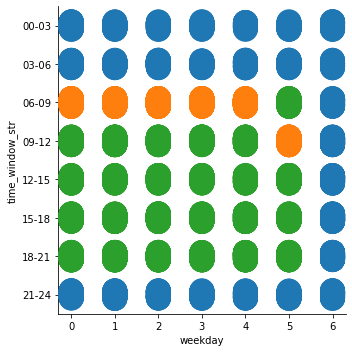

In [96]:
# load data and apply feautre engineering, run clusering
crash_df = create_crash_df(train_file = '../Inputs/Train.csv')

crash_df = create_temporal_features(crash_df)
crash_df = create_cluster_feature(crash_df, strategy='baseline', verbose = 1)
centroids_dict = create_k_means_centroids(crash_df)
submission_df = centroid_to_submission(centroids_dict)
create_submission_csv(submission_df, model_name='test', path='../Outputs/')

In [14]:
calculate_TW_cluster(crash_df)

RTA_count      
            count   sum
cluster                
0              21  2839
1              29  1786
2               3   657
3               2   652
4               1   384

uid            datetime  latitude  longitude  time_window  \
0        1 2018-01-01 00:25:46 -1.188850  36.931382            1   
1        2 2018-01-01 02:02:39 -0.662939  37.208730            1   
2        3 2018-01-01 02:31:49 -0.662939  37.208730            1   
3        4 2018-01-01 03:04:01 -1.288087  36.826583            2   
4        5 2018-01-01 03:58:49 -1.188850  36.931382            2   
5        6 2018-01-01 04:04:09 -0.662939  37.208730            2   
6        7 2018-01-01 05:31:17 -1.165228  36.960008            2   
7        8 2018-01-01 07:57:56 -1.301303  36.820903            3   
8        9 2018-01-01 09:57:27 -1.134640  36.848220            4   
9       10 2018-01-01 10:48:59 -1.117207  37.008278            4   
10      11 2018-01-01 11:23:14 -1.282547  36.827234            4   
11      12 2018-01-01 11:32:24 -1.272261  36.828107            4   
12      13 2018-01-01 14:34:07 -1.605062  37.166918            5   
13      14 2018-01-02 05:13:31 -1.310657  36.805481            2   
14      15 2018-01-02 05:28:15 -1.188841  36.931371            2   
15      16 2018-01-02 07:23:44 -1.264331  36.746984            3   
16      17 2018-01-02 07:25:06 -1.264267  36.746985            3   
17      18 2018-01-02 07:34:35 -1.329837  36.855810            3   
18      19 2018-01-02 07:34:54 -1.264331  36.746984            3   
19      20 2018-01-02 07:37:25 -1.264132  36.754253            3   
20      21 2018-01-02 07:38:40 -1.264331  36.746984            3   
21      22 2018-01-02 07:41:50 -1.264100  36.754252            3   
22      23 2018-01-02 07:54:53 -1.264331  36.746984            3   
23      24 2018-01-02 08:25:13 -1.264331  36.746984            3   
24      25 2018-01-02 09:36:32 -1.167284  36.825383            4   
25      26 2018-01-02 10:14:37 -1.484648  37.137032            4   
26      27 2018-01-02 11:40:51 -0.783330  37.100000            4   
27      28 2018-01-02 11:43:40 -1.119073  36.618408            4   
28      29 2018-01-02 12:53:00 -1.287084  36.818265            5   
29      30 2018-01-02 12:54:35 -1.328522  36.880780            5   
30      31 2018-01-02 13:14:14 -1.292288  36.842388            5   
31      32 2018-01-02 13:16:07 -1.328341  36.881160            5   
32      33 2018-01-02 13:54:06 -1.326197  36.881100            5   
33      34 2018-01-02 14:10:58 -1.483136  37.048284            5   
34      35 2018-01-02 14:17:01 -1.170689  36.972293            5   
35      36 2018-01-02 14:41:44 -1.326197  36.881100            5   
36      37 2018-01-02 15:00:34 -1.326197  36.881100            6   
37      38 2018-01-02 15:03:19 -1.328157  36.870764            6   
38      39 2018-01-02 15:39:32 -1.484648  37.137032            6   
39      40 2018-01-02 16:55:16 -1.262368  36.879087            6   
40      41 2018-01-03 00:46:33 -1.461074  36.963932            1   
41      42 2018-01-03 01:58:56 -1.284649  36.820902            1   
42      43 2018-01-03 02:19:21 -1.284705  36.820904            1   
43      44 2018-01-03 02:19:59 -1.273061  36.812918            1   
44      45 2018-01-03 02:22:36 -1.284784  36.820374            1   
45      46 2018-01-03 02:44:08 -1.283530  36.823728            1   
46      47 2018-01-03 02:47:26 -1.283530  36.823728            1   
47      48 2018-01-03 03:00:32 -1.288409  36.828176            2   
48      49 2018-01-03 03:03:23 -1.283664  36.822608            2   
49      50 2018-01-03 03:09:23 -1.310759  36.799784            2   
50      51 2018-01-03 03:13:26 -1.316599  36.833816            2   
51      52 2018-01-03 03:17:40 -1.283664  36.822608            2   
52      53 2018-01-03 03:33:33 -1.284830  36.821380            2   
53      54 2018-01-03 03:58:34 -1.290814  36.821557            2   
54      55 2018-01-03 04:07:11 -1.316599  36.833816            2   
55      56 2018-01-03 04:18:49 -1.299699  36.807289            2   
56      57 2018-01-03 04:19:52 -1.284807  36.820325            2   
57      58 2018-01-03 04:20:52 -1.451035  36.987778            

In [88]:
def score(submission_df=submission_df, crash_data_df=crash_data_df, test_start_date='2018-01-01'):
    test_df = crash_data_df.loc[crash_data_df.datetime > test_start_date]
    display(test_df.head())
    total_distance = 0
    for date, c_lat, c_lon in test_df[['datetime', 'latitude', 'longitude']].values:
        row = test_df.loc[submission_df.date < date].tail(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

In [70]:
# call function to create submission df and csv output
submission_df, centroids = create_submission_df(crash_data_df)
centroids
#create_submission_csv(submission_df,'star_grid')

array([[-1.19983123, 36.92128143],
       [-2.26993277, 37.38589229],
       [-1.23330826, 36.72098959],
       [-1.29836033, 36.84037964],
       [-1.44752882, 37.0401509 ],
       [-0.98030485, 37.08421802]])

In [50]:
# View contents of submission
submission_df.head()

date  A0_Latitude  A0_Longitude  A1_Latitude  A1_Longitude  \
0 2019-07-01 00:00:00    -1.447529     37.040151    -2.269933     37.385892   
1 2019-07-01 03:00:00    -1.447529     37.040151    -2.269933     37.385892   
2 2019-07-01 06:00:00    -1.447529     37.040151    -2.269933     37.385892   
3 2019-07-01 09:00:00    -1.447529     37.040151    -2.269933     37.385892   
4 2019-07-01 12:00:00    -1.447529     37.040151    -2.269933     37.385892   

   A2_Latitude  A2_Longitude  A3_Latitude  A3_Longitude  A4_Latitude  \
0    -1.233308      36.72099     -0.97529     37.087235     -1.19904   
1    -1.233308      36.72099     -0.97529     37.087235     -1.19904   
2    -1.233308      36.72099     -0.97529     37.087235     -1.19904   
3    -1.233308      36.72099     -0.97529     37.087235     -1.19904   
4    -1.233308      36.72099     -0.97529     37.087235     -1.19904   

   A4_Longitude  A5_Latitude  A5_Longitude  
0     36.922061    -1.298335     36.840378  
1     36.922061    -1.298335     36.840378  
2     36.922061    -1.298335     36.840378  
3     36.922061    -1.298335     36.840378  
4     36.922061    -1.298335     36.840378

In [11]:
# functions for saving post submission details to a dataframe
def get_submission_details(copypaste):
    split_input = re.split("\s", copypaste)
    id_str = split_input[0]
    score_float = split_input[-1]
    file_name = filename = re.findall('\w*.csv\w*', copypaste)[-1]
    comment_str = ''
    submitted_datetime = ''
    submission_row = [id_str, file_name, score_float, submitted_datetime, comment_str]
    return submission_row
def submission_dataframe(rows,columns=['ID', 'FILE', 'SCORE', 'SUBMITTED', 'COMMENT']):
    return pd.DataFrame(data=[rows], columns = columns)

def create_dataframe(copypaste):
    return submission_dataframe(get_submission_details(copypaste))

# the below needs work
def add_to_submission_dataframe(df, rows, columns=['ID', 'FILE', 'SCORE', 'SUBMITTED', 'COMMENT']):
    return df.append(zip([columns,rows]), ignore_index=True)

def update_dataframe(df, copypaste):
    rows = get_submission_details(copypaste)
    return add_to_submission_dataframe(df, rows)